# Imitation Learning notebook - Inverse Reinforcement Learning - Use rewards from sliced RL to imitate expert behavioural movements 

In [1]:
import gym
import numpy as np
import cvxpy as cp
import sys
import pylab
import matplotlib.pyplot as plt
import pandas as pd 
import torch
from torch.autograd import Variable
import copy
import torch.nn.functional as F
import random
import torch.nn as nn
import math
from itertools import count
from PIL import Image
import torch
import torch.optim 
import torchvision.transforms as transforms
from collections import namedtuple, deque
from torch import nn
from gym import make
import torch.optim as optim
from numpy import save
from tqdm.notebook import tqdm
import pickle

import pickle
from typing import Optional
import IPython
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from Code.utils import Net, Memory, Agent
from Code.sliced_wasserstein_rewards import *
from Code.plotting import preprocess_states, animate
from Code.helper_functions import *

### Load expert trajectories 

In [3]:
environment = 'Pendulum-v0'

t1 = 'multi_diff_lengths_excl_1'
traj1 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t1,environment))

t2 = 'multi_same_lengths_1_5'
traj2 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t2,environment))

t3 = 'multi_same_lengths_0_3'
traj3 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t3,environment))

t4 = 'multi_same_lengths_1'
traj4 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t4,environment))

t5 = 'simple_length_1'
traj5 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t5,environment))

t6 = 'simple_length_1_5'
traj6 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t6,environment))

t7 = 'simple_length_0_3'
traj7 = np.load('/Users/ilanasebag/Documents/Thesis_Code/RL_results/%s_exp_states_%s.npy'%(t7,environment))

### Imitation Learning

In [4]:
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

In [5]:
def main(environment, exp, simple = False, MMOT = False, wass_PWIL = False, PWIL = False):

    env = gym.make(environment)

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.shape[0]
    action_dim = env.action_space.shape[0] * 5 #discretization  of the unique continuous action of the pendulum

    agent = Agent(input_dim, output_dim, action_dim, environment)

    training_records = []
    running_reward, running_q = -1000, 0
    

    for i_ep in range(900):

        rewards = []
        new_states = []
        old_states = []
        action_indexes = []

        score = 0

        #We fix the departure state 
        state = env.reset()
        env.env.state = np.array([np.pi/2, 0.5])
        env.env.last_u = None
        state = env.env._get_obs()
        
        #to make it more robust we have to use :
        #state = env.reset()
        
        for t in range(200):
            action, action_index = agent.select_action(state)
            state_, reward, done, _ = env.step(action)
            score += reward
            old_states.append(state)

            env.render()
            #agent.store_transition(Transition(state, action_index, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

            action_indexes.append(action_index)
            rewards.append(reward)
            new_states.append(state_)

        states_tens = [torch.tensor(elt) for elt in old_states] #agent rollout 
        states_tens = torch.stack(states_tens).float()

        
        if MMOT is True :
            rewards_multitask = rewarder_multi([states_tens, torch.tensor(exp[0]).float(), torch.tensor(exp[1]).float(), torch.tensor(exp[2]).float(), torch.tensor(exp[3]).float(), torch.tensor(exp[4]).float()], num_projections = 50)
        
        elif simple is True : 
            rewards_multitask = rewarder_multi([states_tens, torch.tensor(exp[0]).float()], num_projections = 50)
            
        elif wass_PWIL is True : 
            pwil_exp = torch.tensor(concatenate_and_sample(exp)).float()
            rewards_multitask = rewarder_multi([states_tens, pwil_exp], num_projections = 50)
            
            
        for t in range(200):
            rewards[t] = torch.exp(-5*rewards_multitask[t,0])
            agent.store_transition(Transition(old_states[t], action_indexes[t], rewards[t], new_states[t]))

        running_reward = running_reward * 0.9 + score * 0.1
        training_records.append(TrainingRecord(i_ep, running_reward))

        print('Ep', i_ep, 'Average score:', running_reward, 'score of current env', score )

    env.close()
    
    return training_records
    
    
    

#### Unique expert trajectory


In [27]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj5
    training_record_simple_l_1 = main(environment, exp, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -1034.6279102424435 score of current env -1346.2791024244343
Ep 1 Average score: -1058.5328007271048 score of current env -1273.676815089056
Ep 2 Average score: -1098.6944992069102 score of current env -1460.1497855251587
Ep 3 Average score: -1129.8895268755557 score of current env -1410.6447758933637
Ep 4 Average score: -1150.5760628238265 score of current env -1336.7548863582635
Ep 5 Average score: -1170.5465481425672 score of current env -1350.2809160112333
Ep 6 Average score: -1187.90628712353 score of current env -1344.1439379521958
Ep 7 Average score: -1212.3820666998913 score of current env -1432.664082887143
Ep 8 Average score: -1220.2803288278524 score of current env -1291.3646879795003
Ep 9 Average score: -1230.3357346537684 score of current env -1320.834387087013
Ep 10 Average score: -1240.1202726591832 score of current env -1328.181114707916
Ep 11 Average score: -1225.0281327615396 score of current env -1089.1988736827473
Ep 12 Average score: -1235.35082

Ep 101 Average score: -177.79382252339357 score of current env -246.94537847939895
Ep 102 Average score: -171.85660153175485 score of current env -118.42161260700625
Ep 103 Average score: -166.47569249206737 score of current env -118.04751113488007
Ep 104 Average score: -161.91266752860406 score of current env -120.84544285743405
Ep 105 Average score: -157.540808976964 score of current env -118.19408201220331
Ep 106 Average score: -153.60333614499808 score of current env -118.16608065730469
Ep 107 Average score: -150.04889777975814 score of current env -118.05895249259866
Ep 108 Average score: -146.76842429020553 score of current env -117.24416288423214
Ep 109 Average score: -143.81337127420116 score of current env -117.21789413016184
Ep 110 Average score: -141.17449353907887 score of current env -117.4245939229783
Ep 111 Average score: -138.7912172968979 score of current env -117.34173111726933
Ep 112 Average score: -136.63091853894153 score of current env -117.18822971733391
Ep 113 A

Ep 201 Average score: -118.87545649096717 score of current env -117.26900524850755
Ep 202 Average score: -118.72743185344822 score of current env -117.39521011577766
Ep 203 Average score: -118.58453593427502 score of current env -117.2984726617162
Ep 204 Average score: -118.4809151107613 score of current env -117.54832769913779
Ep 205 Average score: -118.36545825272356 score of current env -117.32634653038382
Ep 206 Average score: -118.28559122522114 score of current env -117.5667879776994
Ep 207 Average score: -118.20936109686421 score of current env -117.52328994165183
Ep 208 Average score: -118.1209182941943 score of current env -117.32493307016503
Ep 209 Average score: -118.06140988343597 score of current env -117.52583418661102
Ep 210 Average score: -118.00343723432668 score of current env -117.48168339234314
Ep 211 Average score: -118.06865354266299 score of current env -118.65560031768966
Ep 212 Average score: -118.0262037111273 score of current env -117.64415522730597
Ep 213 Av

In [28]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj6
    training_record_simple_l_1_5 = main(environment, exp, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -1039.5973932400657 score of current env -1395.973932400656
Ep 1 Average score: -1070.8393636020353 score of current env -1352.017096859761
Ep 2 Average score: -1108.5707236400972 score of current env -1448.1529639826542
Ep 3 Average score: -1128.9085219786148 score of current env -1311.9487070252721
Ep 4 Average score: -1139.2695771582514 score of current env -1232.519073774981
Ep 5 Average score: -1158.6239592598538 score of current env -1332.813398174276
Ep 6 Average score: -1176.5734085563279 score of current env -1338.1184522245942
Ep 7 Average score: -1186.607036719429 score of current env -1276.9096901873406
Ep 8 Average score: -1188.0393769249924 score of current env -1200.930438775062
Ep 9 Average score: -1216.9715639719507 score of current env -1477.3612473945734
Ep 10 Average score: -1229.6802544255474 score of current env -1344.0584685079161
Ep 11 Average score: -1251.8114877830856 score of current env -1450.9925880009287
Ep 12 Average score: -1263.95263

Ep 101 Average score: -581.9611115245875 score of current env -1104.7430037017473
Ep 102 Average score: -536.3443430813606 score of current env -125.79342709231838
Ep 103 Average score: -634.158263076886 score of current env -1514.4835430366145
Ep 104 Average score: -735.1338375226863 score of current env -1643.914007534889
Ep 105 Average score: -820.800255543582 score of current env -1591.798017731643
Ep 106 Average score: -895.9099632920764 score of current env -1571.8973330285255
Ep 107 Average score: -947.0094119853603 score of current env -1406.9044502249155
Ep 108 Average score: -896.1895464530971 score of current env -438.8107566627292
Ep 109 Average score: -818.33146021841 score of current env -117.60868410622554
Ep 110 Average score: -748.2386361804699 score of current env -117.40321983900874
Ep 111 Average score: -685.2385066523738 score of current env -118.23734089950734
Ep 112 Average score: -723.8826417927728 score of current env -1071.6798580563632
Ep 113 Average score: -

Ep 201 Average score: -119.1807219932826 score of current env -119.03660484584687
Ep 202 Average score: -119.34102813101826 score of current env -120.78378337063927
Ep 203 Average score: -119.38229009791448 score of current env -119.75364779998047
Ep 204 Average score: -119.52044318792868 score of current env -120.76382099805637
Ep 205 Average score: -119.47026257697507 score of current env -119.01863707839266
Ep 206 Average score: -119.61748594243429 score of current env -120.94249623156705
Ep 207 Average score: -119.57450949222306 score of current env -119.18772144032211
Ep 208 Average score: -119.535736633389 score of current env -119.18678090388258
Ep 209 Average score: -119.53330028239762 score of current env -119.51137312347515
Ep 210 Average score: -119.651471040206 score of current env -120.71500786048152
Ep 211 Average score: -119.60870495118641 score of current env -119.22381015001012
Ep 212 Average score: -119.65061233973452 score of current env -120.02777883666748
Ep 213 Av

In [29]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj7
    training_record_simple_l_0_3 = main(environment, exp, simple = True, MMOT = False, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -1034.2763596936493 score of current env -1342.7635969364917
Ep 1 Average score: -1080.6039269711916 score of current env -1497.5520324690735
Ep 2 Average score: -1086.1892609181152 score of current env -1136.4572664404275
Ep 3 Average score: -1111.3003542986949 score of current env -1337.3001947239109
Ep 4 Average score: -1134.9626428099837 score of current env -1347.9232394115834
Ep 5 Average score: -1127.8213286253058 score of current env -1063.549500963204
Ep 6 Average score: -1104.100804024805 score of current env -890.6160826202982
Ep 7 Average score: -1125.147873940851 score of current env -1314.571503185264
Ep 8 Average score: -1161.4498983191586 score of current env -1488.1681177239261
Ep 9 Average score: -1182.2796201673782 score of current env -1369.7471168013549
Ep 10 Average score: -1173.158087274931 score of current env -1091.064291242905
Ep 11 Average score: -1198.1594988108711 score of current env -1423.1722026343325
Ep 12 Average score: -1238.833028

Ep 101 Average score: -253.09864444505345 score of current env -121.23706416304064
Ep 102 Average score: -239.66798492580364 score of current env -118.79204925255533
Ep 103 Average score: -227.56929629370848 score of current env -118.68109860485197
Ep 104 Average score: -229.33259812978218 score of current env -245.20231465444533
Ep 105 Average score: -218.66591563652 score of current env -122.6657731971602
Ep 106 Average score: -233.97540595534213 score of current env -371.7608188247412
Ep 107 Average score: -247.36650718387847 score of current env -367.8864182407054
Ep 108 Average score: -247.53962169444225 score of current env -249.09765228951613
Ep 109 Average score: -247.64600899030847 score of current env -248.60349465310443
Ep 110 Average score: -248.6670438638467 score of current env -257.8563577256905
Ep 111 Average score: -260.8795798743329 score of current env -370.79240396870887
Ep 112 Average score: -272.09419021918023 score of current env -373.0256833228062
Ep 113 Average

Ep 202 Average score: -1127.4243256372338 score of current env -468.2149321187519
Ep 203 Average score: -1052.815590102385 score of current env -381.3369702887456
Ep 204 Average score: -985.8301777875749 score of current env -382.96146695428445
Ep 205 Average score: -937.2145163952667 score of current env -499.6735638644934
Ep 206 Average score: -893.0531122254692 score of current env -495.6004746972916
Ep 207 Average score: -853.3706718628958 score of current env -496.2287085997355
Ep 208 Average score: -817.6878356254963 score of current env -496.54230948889966
Ep 209 Average score: -785.7262625484932 score of current env -498.07210485546494
Ep 210 Average score: -756.9049166695798 score of current env -497.5128037593598
Ep 211 Average score: -731.0167786684162 score of current env -498.0235366579435
Ep 212 Average score: -707.4801763415704 score of current env -495.65075539995723
Ep 213 Average score: -688.1698232556142 score of current env -514.3766454820084
Ep 214 Average score: -

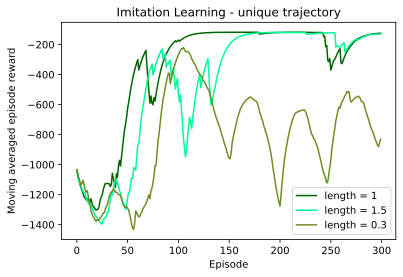

In [30]:
plt.plot([r.ep for r in training_record_simple_l_1], [r.reward for r in training_record_simple_l_1], color = 'darkgreen')
plt.plot([r.ep for r in training_record_simple_l_1_5], [r.reward for r in training_record_simple_l_1_5], color = 'mediumspringgreen')
plt.plot([r.ep for r in training_record_simple_l_0_3], [r.reward for r in training_record_simple_l_0_3], color = 'olivedrab')

plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
    
plt.title('Imitation Learning - unique trajectory')
plt.legend(["length = 1", "length = 1.5", "length = 0.3"])

plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/unique_trajectory_environment_rewards_%s.png"%environment)

plt.show()


#### 5 expert trajectories of same length

In [31]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj2
    training_record_multiple_l_1_5_MMOT = main(environment, exp, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -1009.9598926576043 score of current env -1099.5989265760425
Ep 1 Average score: -1030.0310868315491 score of current env -1210.6718343970522
Ep 2 Average score: -1073.9179998762877 score of current env -1468.9002172789337
Ep 3 Average score: -1112.7474784157064 score of current env -1462.212785270473
Ep 4 Average score: -1136.8516542963032 score of current env -1353.7892372216743
Ep 5 Average score: -1163.2232554814625 score of current env -1400.5676661478951
Ep 6 Average score: -1185.923510137012 score of current env -1390.2258020369566
Ep 7 Average score: -1216.1364056233328 score of current env -1488.0524650002192
Ep 8 Average score: -1227.2742451732743 score of current env -1327.5148011227475
Ep 9 Average score: -1211.6715113608225 score of current env -1071.246907048755
Ep 10 Average score: -1216.7591389154452 score of current env -1262.547786907048
Ep 11 Average score: -1228.53180464083 score of current env -1334.485796169292
Ep 12 Average score: -1225.934040

Ep 102 Average score: -484.2354740703885 score of current env -1194.156055034297
Ep 103 Average score: -500.06321057433826 score of current env -642.512839109886
Ep 104 Average score: -461.82791162729154 score of current env -117.7102211038709
Ep 105 Average score: -539.4532137598741 score of current env -1238.0809329531164
Ep 106 Average score: -612.4190519836775 score of current env -1269.1115959979086
Ep 107 Average score: -681.7149263416751 score of current env -1305.377795563653
Ep 108 Average score: -734.192363441474 score of current env -1206.489297339664
Ep 109 Average score: -672.7149910055957 score of current env -119.41863908269116
Ep 110 Average score: -690.7202935092434 score of current env -852.7680160420726
Ep 111 Average score: -633.3920676936846 score of current env -117.4380353536548
Ep 112 Average score: -582.0167476254451 score of current env -119.63886701128901
Ep 113 Average score: -535.8020270587796 score of current env -119.86954195879026
Ep 114 Average score: -

Ep 202 Average score: -137.2330620124021 score of current env -126.47392977091921
Ep 203 Average score: -136.15475272258925 score of current env -126.44996911427356
Ep 204 Average score: -135.19318173613922 score of current env -126.53904285808882
Ep 205 Average score: -134.3026998216933 score of current env -126.28836259168011
Ep 206 Average score: -133.25098549569546 score of current env -123.78555656171488
Ep 207 Average score: -132.13444200397095 score of current env -122.08555057845037
Ep 208 Average score: -131.1027515330203 score of current env -121.81753729446426
Ep 209 Average score: -130.6645676275686 score of current env -126.72091247850341
Ep 210 Average score: -130.2541663267091 score of current env -126.5605546189736
Ep 211 Average score: -129.90304006142145 score of current env -126.74290367383263
Ep 212 Average score: -129.3533845430901 score of current env -124.40648487810775
Ep 213 Average score: -129.08778100193447 score of current env -126.69734913153376
Ep 214 Aver

In [32]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj2
    training_record_multiple_l_1_5_wass_PWIL = main(environment, exp, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -1034.6261198340799 score of current env -1346.2611983407976
Ep 1 Average score: -1070.6575890415195 score of current env -1394.940811908477
Ep 2 Average score: -1102.486392060097 score of current env -1388.9456192272942
Ep 3 Average score: -1115.7086633586775 score of current env -1234.7091050459019
Ep 4 Average score: -1135.2197752748843 score of current env -1310.819782520746
Ep 5 Average score: -1134.639856299435 score of current env -1129.4205855203911
Ep 6 Average score: -1144.8303495377284 score of current env -1236.544788682369
Ep 7 Average score: -1163.8510947390782 score of current env -1335.0378015512265
Ep 8 Average score: -1184.7255263824916 score of current env -1372.5954111732106
Ep 9 Average score: -1198.3893980517366 score of current env -1321.364243074943
Ep 10 Average score: -1215.5974149110243 score of current env -1370.4695666446128
Ep 11 Average score: -1210.7390739716677 score of current env -1167.0140055174586
Ep 12 Average score: -1232.92452

Ep 101 Average score: -167.92047326401126 score of current env -126.48826683494883
Ep 102 Average score: -164.07471919246726 score of current env -129.46293254857133
Ep 103 Average score: -160.5770078609563 score of current env -129.09760587735738
Ep 104 Average score: -157.23673316431683 score of current env -127.17426089456194
Ep 105 Average score: -154.52699560288607 score of current env -130.1393575500093
Ep 106 Average score: -151.99467478096815 score of current env -129.2037873837069
Ep 107 Average score: -149.70351330806028 score of current env -129.08306005188922
Ep 108 Average score: -147.14806284379554 score of current env -124.14900866541284
Ep 109 Average score: -144.84349925740787 score of current env -124.10242697991893
Ep 110 Average score: -142.69429966978612 score of current env -123.35150338119044
Ep 111 Average score: -140.82841091661186 score of current env -124.03541213804343
Ep 112 Average score: -139.19698688502467 score of current env -124.51417060074
Ep 113 Ave

Ep 201 Average score: -131.74382854698655 score of current env -131.12019531504643
Ep 202 Average score: -131.78843000974965 score of current env -132.18984317461758
Ep 203 Average score: -131.8015971224847 score of current env -131.92010113710032
Ep 204 Average score: -131.764653540106 score of current env -131.43216129869748
Ep 205 Average score: -132.15989684903093 score of current env -135.71708662935546
Ep 206 Average score: -132.16717810616575 score of current env -132.2327094203792
Ep 207 Average score: -132.52046872566135 score of current env -135.70008430112162
Ep 208 Average score: -132.83632181505658 score of current env -135.67899961961365
Ep 209 Average score: -133.11099187025968 score of current env -135.5830223670876
Ep 210 Average score: -133.1628044301248 score of current env -133.62911746891078
Ep 211 Average score: -133.4696065366096 score of current env -136.23082549497275
Ep 212 Average score: -133.4560857332035 score of current env -133.3343985025486
Ep 213 Averag

In [33]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj3
    training_record_multiple_l_0_3_MMOT = main(environment, exp, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -1037.6855638790134 score of current env -1376.8556387901353
Ep 1 Average score: -1041.6949258453474 score of current env -1077.7791835423527
Ep 2 Average score: -1072.2451756873572 score of current env -1347.197424265447
Ep 3 Average score: -1099.3670028683455 score of current env -1343.4634474972386
Ep 4 Average score: -1095.6292603273675 score of current env -1061.989577458565
Ep 5 Average score: -1135.5439920898787 score of current env -1494.7765779524786
Ep 6 Average score: -1157.0826465965606 score of current env -1350.9305371566984
Ep 7 Average score: -1175.2351724248872 score of current env -1338.607904879826
Ep 8 Average score: -1199.2036921537424 score of current env -1414.9203697134376
Ep 9 Average score: -1219.383352475241 score of current env -1401.0002953687288
Ep 10 Average score: -1204.072294809192 score of current env -1066.272775814751
Ep 11 Average score: -1207.6753464025269 score of current env -1240.10281074254
Ep 12 Average score: -1194.0692062

Ep 102 Average score: -340.20410361884575 score of current env -118.55189628124964
Ep 103 Average score: -318.21688964185876 score of current env -120.33196384897579
Ep 104 Average score: -298.3118031633315 score of current env -119.16602485658606
Ep 105 Average score: -280.6057978370388 score of current env -121.25174990040438
Ep 106 Average score: -264.90370704453795 score of current env -123.58488991203069
Ep 107 Average score: -322.34932238233273 score of current env -839.3598604224856
Ep 108 Average score: -302.5697750848013 score of current env -124.55384940701849
Ep 109 Average score: -284.31023596177215 score of current env -119.97438385451001
Ep 110 Average score: -267.72460703546824 score of current env -118.45394669873308
Ep 111 Average score: -252.95593662380404 score of current env -120.03790291882613
Ep 112 Average score: -239.7056416722254 score of current env -120.4529871080176
Ep 113 Average score: -227.8213865545111 score of current env -120.86309049508229
Ep 114 Aver

Ep 202 Average score: -127.41788848451152 score of current env -125.82324009648643
Ep 203 Average score: -127.08729910967348 score of current env -124.11199473613104
Ep 204 Average score: -126.75403706541832 score of current env -123.75467866712188
Ep 205 Average score: -126.62836746282221 score of current env -125.49734103945725
Ep 206 Average score: -150.26210011844609 score of current env -362.96569401906095
Ep 207 Average score: -147.54937856314854 score of current env -123.13488456547041
Ep 208 Average score: -145.1139336965291 score of current env -123.19492989695429
Ep 209 Average score: -142.70670049920818 score of current env -121.04160172331973
Ep 210 Average score: -140.67129606171358 score of current env -122.35265612426221
Ep 211 Average score: -139.10564274045674 score of current env -125.0147628491451
Ep 212 Average score: -137.7905219268028 score of current env -125.95443460391725
Ep 213 Average score: -136.276753537599 score of current env -122.65283803476501
Ep 214 Av

In [34]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj3
    training_record_multiple_l_0_3_wass_PWIL = main(environment, exp, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -1031.6026512963506 score of current env -1316.0265129635056
Ep 1 Average score: -1077.2321997558872 score of current env -1487.898135891717
Ep 2 Average score: -1107.1165469505543 score of current env -1376.0756717025577
Ep 3 Average score: -1141.5274655061162 score of current env -1451.2257325061726
Ep 4 Average score: -1162.8160343315926 score of current env -1354.4131537608785
Ep 5 Average score: -1196.0794521474425 score of current env -1495.450212490091
Ep 6 Average score: -1220.2966180350238 score of current env -1438.2511110232545
Ep 7 Average score: -1223.094396548604 score of current env -1248.2744031708273
Ep 8 Average score: -1233.309970037204 score of current env -1325.2501314346052
Ep 9 Average score: -1239.7955678856833 score of current env -1298.165948521997
Ep 10 Average score: -1258.2915228270292 score of current env -1424.7551172991414
Ep 11 Average score: -1267.857502331427 score of current env -1353.9513178710054
Ep 12 Average score: -1303.68102

Ep 101 Average score: -1024.08135551771 score of current env -1304.834907816562
Ep 102 Average score: -959.2416930189938 score of current env -375.68473053054754
Ep 103 Average score: -888.3511759762495 score of current env -250.3365225915497
Ep 104 Average score: -811.7750249770514 score of current env -122.58966598426892
Ep 105 Average score: -755.4915263612806 score of current env -248.94003881934336
Ep 106 Average score: -691.8224050898655 score of current env -118.80031364712848
Ep 107 Average score: -659.6741001945848 score of current env -370.33935613705796
Ep 108 Average score: -618.5039915242289 score of current env -247.97301349102696
Ep 109 Average score: -581.3786030878081 score of current env -247.2501071600201
Ep 110 Average score: -571.8594879172308 score of current env -486.1874513820353
Ep 111 Average score: -552.5343055275807 score of current env -378.60766402072903
Ep 112 Average score: -540.3604750789167 score of current env -430.7960010409398
Ep 113 Average score: 

Ep 202 Average score: -1069.9286963351044 score of current env -1091.4485691592236
Ep 203 Average score: -1063.0843962805088 score of current env -1001.4856957891473
Ep 204 Average score: -1051.9593992334285 score of current env -951.8344258097055
Ep 205 Average score: -1068.8328002516016 score of current env -1220.6934094151595
Ep 206 Average score: -1081.8871484545166 score of current env -1199.3762822807507
Ep 207 Average score: -1087.6257605145056 score of current env -1139.2732690544067
Ep 208 Average score: -1094.4458580735052 score of current env -1155.8267361045016
Ep 209 Average score: -1105.6121665603832 score of current env -1206.1089429422861
Ep 210 Average score: -1115.3870712810062 score of current env -1203.3612137666125
Ep 211 Average score: -1124.3823522737732 score of current env -1205.339881208676
Ep 212 Average score: -1131.3735563424996 score of current env -1194.2943929610358
Ep 213 Average score: -1136.2817107604176 score of current env -1180.4551005216797
Ep 214

In [35]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj4
    training_record_multiple_l_1_MMOT = main(environment, exp, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -1032.3504757271426 score of current env -1323.5047572714248
Ep 1 Average score: -1059.733118773304 score of current env -1306.1769061887585
Ep 2 Average score: -1102.1983961630501 score of current env -1484.3858926707633
Ep 3 Average score: -1122.9857155944437 score of current env -1310.071590476986
Ep 4 Average score: -1146.035115843336 score of current env -1353.4797180833646
Ep 5 Average score: -1141.9991813378829 score of current env -1105.675770788805
Ep 6 Average score: -1149.8926479022973 score of current env -1220.9338469820275
Ep 7 Average score: -1166.0036674277424 score of current env -1311.002843156747
Ep 8 Average score: -1192.9121686557305 score of current env -1435.0886797076248
Ep 9 Average score: -1218.6577629888593 score of current env -1450.3681119870178
Ep 10 Average score: -1245.8621718539848 score of current env -1490.701851640116
Ep 11 Average score: -1259.2176180811748 score of current env -1379.4166341258842
Ep 12 Average score: -1280.13882

Ep 102 Average score: -197.35969631801873 score of current env -117.55656742212629
Ep 103 Average score: -189.37079004436112 score of current env -117.47063358144263
Ep 104 Average score: -182.20699001109404 score of current env -117.7327897116901
Ep 105 Average score: -175.76327901111748 score of current env -117.76988001132841
Ep 106 Average score: -169.98858993058928 score of current env -118.01638820583534
Ep 107 Average score: -216.58255601150452 score of current env -635.9282507397414
Ep 108 Average score: -206.7514309280268 score of current env -118.27130517672711
Ep 109 Average score: -197.90181109054265 score of current env -118.2552325531852
Ep 110 Average score: -355.01594347651735 score of current env -1769.0431349502899
Ep 111 Average score: -506.2198236436628 score of current env -1867.0547451479717
Ep 112 Average score: -479.99066922732015 score of current env -243.92827948023648
Ep 113 Average score: -443.73767334941596 score of current env -117.46071044827809
Ep 114 Av

Ep 202 Average score: -118.12189805139033 score of current env -117.91525537646385
Ep 203 Average score: -118.11283280390016 score of current env -118.03124557648852
Ep 204 Average score: -118.08730421654164 score of current env -117.8575469303149
Ep 205 Average score: -118.08331258836684 score of current env -118.04738793479363
Ep 206 Average score: -118.06106534895429 score of current env -117.86084019424143
Ep 207 Average score: -118.08870579881007 score of current env -118.33746984751201
Ep 208 Average score: -118.10707300023648 score of current env -118.27237781307417
Ep 209 Average score: -118.13947774500281 score of current env -118.43112044789983
Ep 210 Average score: -118.1533880265836 score of current env -118.27858056081065
Ep 211 Average score: -118.36418496109704 score of current env -120.26135737171802
Ep 212 Average score: -118.39469491293406 score of current env -118.66928447946727
Ep 213 Average score: -118.48012173280335 score of current env -119.24896311162692
Ep 214

In [36]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj4
    training_record_multiple_l_1_wass_PWIL = main(environment, exp, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -1031.8857202345525 score of current env -1318.8572023455245
Ep 1 Average score: -1048.4431849668417 score of current env -1197.4603675574435
Ep 2 Average score: -1092.552606933232 score of current env -1489.5374046307454
Ep 3 Average score: -1129.003136420016 score of current env -1457.0579018010712
Ep 4 Average score: -1137.1909869201809 score of current env -1210.8816414216649
Ep 5 Average score: -1157.078378921556 score of current env -1336.0649069339308
Ep 6 Average score: -1171.5290577733012 score of current env -1301.5851674390103
Ep 7 Average score: -1185.5394152058395 score of current env -1311.632632098683
Ep 8 Average score: -1215.2434400994514 score of current env -1482.5796641419583
Ep 9 Average score: -1233.9681355342452 score of current env -1402.4903944473888
Ep 10 Average score: -1239.3008080278055 score of current env -1287.2948604698458
Ep 11 Average score: -1220.7742450721144 score of current env -1054.0351784708946
Ep 12 Average score: -1234.552

Ep 102 Average score: -851.4168581092455 score of current env -128.89349312633087
Ep 103 Average score: -778.5787428042148 score of current env -123.03570505893894
Ep 104 Average score: -713.0280949831913 score of current env -123.07226459397931
Ep 105 Average score: -654.0892358666191 score of current env -123.63950381746864
Ep 106 Average score: -600.496015381266 score of current env -118.15703101308839
Ep 107 Average score: -552.3239952776113 score of current env -118.77581434471874
Ep 108 Average score: -508.93185088969426 score of current env -118.40255139844105
Ep 109 Average score: -469.8899131786884 score of current env -118.51247377963549
Ep 110 Average score: -460.2500208396016 score of current env -373.49098978782047
Ep 111 Average score: -426.04076105786584 score of current env -118.15742302224429
Ep 112 Average score: -395.27166648124745 score of current env -118.34981529168188
Ep 113 Average score: -367.56815756187723 score of current env -118.23657728754554
Ep 114 Averag

Ep 202 Average score: -123.00808112347511 score of current env -120.26381617222917
Ep 203 Average score: -122.64254599524627 score of current env -119.35272984118669
Ep 204 Average score: -122.44749594846726 score of current env -120.6920455274561
Ep 205 Average score: -122.13888738100272 score of current env -119.36141027382172
Ep 206 Average score: -122.14268201504986 score of current env -122.17683372147401
Ep 207 Average score: -122.14684543471901 score of current env -122.18431621174128
Ep 208 Average score: -122.11606617456016 score of current env -121.83905283313054
Ep 209 Average score: -121.88186921387593 score of current env -119.77409656771779
Ep 210 Average score: -121.70524215123358 score of current env -120.11559858745244
Ep 211 Average score: -121.70023513005526 score of current env -121.65517193945041
Ep 212 Average score: -121.67932635225242 score of current env -121.49114735202666
Ep 213 Average score: -121.62486958168418 score of current env -121.13475864656999
Ep 21

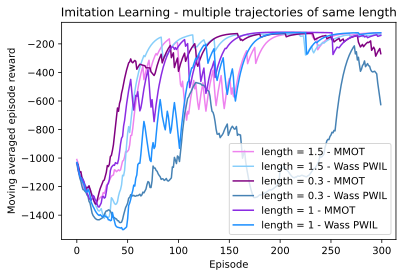

In [37]:
plt.plot([r.ep for r in training_record_multiple_l_1_5_MMOT], [r.reward for r in training_record_multiple_l_1_5_MMOT], color = 'violet')
plt.plot([r.ep for r in training_record_multiple_l_1_5_wass_PWIL], [r.reward for r in training_record_multiple_l_1_5_wass_PWIL], color = 'lightskyblue')
plt.plot([r.ep for r in training_record_multiple_l_0_3_MMOT], [r.reward for r in training_record_multiple_l_0_3_MMOT], color = 'purple')
plt.plot([r.ep for r in training_record_multiple_l_0_3_wass_PWIL], [r.reward for r in training_record_multiple_l_0_3_wass_PWIL], color = 'steelblue')
plt.plot([r.ep for r in training_record_multiple_l_1_MMOT], [r.reward for r in training_record_multiple_l_1_MMOT], color = 'blueviolet')
plt.plot([r.ep for r in training_record_multiple_l_1_wass_PWIL], [r.reward for r in training_record_multiple_l_1_wass_PWIL], color = 'dodgerblue')

plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
    
plt.title('Imitation Learning - multiple trajectories of same length')
plt.legend(["length = 1.5 - MMOT","length = 1.5 - Wass PWIL", "length = 0.3 - MMOT", "length = 0.3 - Wass PWIL",
            "length = 1 - MMOT", "length = 1 - Wass PWIL" ])

plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/mult_traj_same_len_environment_rewards_%s.png"%environment)


plt.show()


#### 5 expert trajectories of different length

In [9]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj1
    training_records_diff_len_MMOT = main(environment, exp, simple = False, MMOT = True, wass_PWIL = False, PWIL = False)

Ep 0 Average score: -1031.370559268658 score of current env -1313.7055926865808
Ep 1 Average score: -1047.1895858587095 score of current env -1189.5608251691722
Ep 2 Average score: -1076.9007600123693 score of current env -1344.3013273953072
Ep 3 Average score: -1092.552753069515 score of current env -1233.420690583824
Ep 4 Average score: -1118.5331032496538 score of current env -1352.356254870903
Ep 5 Average score: -1114.5397509532208 score of current env -1078.5995802853236
Ep 6 Average score: -1141.561739349721 score of current env -1384.7596349182215
Ep 7 Average score: -1155.106238195003 score of current env -1277.006727802541
Ep 8 Average score: -1168.918757143645 score of current env -1293.2314276814238
Ep 9 Average score: -1182.6756301067921 score of current env -1306.4874867751155
Ep 10 Average score: -1194.921050425719 score of current env -1305.1298332960585
Ep 11 Average score: -1226.2321254992585 score of current env -1508.0318011611132
Ep 12 Average score: -1254.15131858

Ep 102 Average score: -227.3811222505032 score of current env -254.70378988504433
Ep 103 Average score: -229.56638622115207 score of current env -249.23376195699177
Ep 104 Average score: -231.79191690669634 score of current env -251.82169307659478
Ep 105 Average score: -241.38932891454408 score of current env -327.7660369851736
Ep 106 Average score: -242.41904378479725 score of current env -251.68647761707584
Ep 107 Average score: -251.22895209050768 score of current env -330.5181268419015
Ep 108 Average score: -263.3309055567145 score of current env -372.2484867525761
Ep 109 Average score: -274.14782922051324 score of current env -371.50014219470165
Ep 110 Average score: -276.26138917181873 score of current env -295.2834287335684
Ep 111 Average score: -285.8091646250238 score of current env -371.7391437038693
Ep 112 Average score: -282.5594640789306 score of current env -253.3121591640918
Ep 113 Average score: -291.66168892364794 score of current env -373.5817125261037
Ep 114 Average 

Ep 202 Average score: -225.33398278836697 score of current env -372.8681927063246
Ep 203 Average score: -241.8369547966733 score of current env -390.36370287143035
Ep 204 Average score: -242.8627474487343 score of current env -252.09488131728327
Ep 205 Average score: -231.8779634936109 score of current env -133.01490789750042
Ep 206 Average score: -221.99371073782265 score of current env -133.0354359357285
Ep 207 Average score: -236.74042915759125 score of current env -369.4608949355086
Ep 208 Average score: -226.36992983540497 score of current env -133.0354359357285
Ep 209 Average score: -216.9778185408151 score of current env -132.44881688950608
Ep 210 Average score: -220.45403121355722 score of current env -251.73994526823623
Ep 211 Average score: -211.53235005307914 score of current env -131.23721960877634
Ep 212 Average score: -203.5373860595531 score of current env -131.58271011781906
Ep 213 Average score: -208.39372148166163 score of current env -252.10074028063806
Ep 214 Averag

Ep 302 Average score: -134.86244353005267 score of current env -122.17585907755571
Ep 303 Average score: -133.87514560436017 score of current env -124.98946427312768
Ep 304 Average score: -132.6673340578771 score of current env -121.79703013952937
Ep 305 Average score: -131.963719775109 score of current env -125.63119123019607
Ep 306 Average score: -131.36053501786515 score of current env -125.9318722026703
Ep 307 Average score: -130.3741365931701 score of current env -121.49655077091472
Ep 308 Average score: -129.7528231492946 score of current env -124.16100215441517
Ep 309 Average score: -129.48859023608782 score of current env -127.1104940172267
Ep 310 Average score: -128.63609233819 score of current env -120.96361125710955
Ep 311 Average score: -127.92763509514367 score of current env -121.55151990772673
Ep 312 Average score: -139.7482698544768 score of current env -246.133982688475
Ep 313 Average score: -137.93178511901965 score of current env -121.5834224999054
Ep 314 Average sco

Ep 402 Average score: -227.88084137062629 score of current env -123.62209329603647
Ep 403 Average score: -217.38055315378904 score of current env -122.87795920225354
Ep 404 Average score: -207.89597008948584 score of current env -122.53472251075681
Ep 405 Average score: -199.18296651548616 score of current env -120.76593434948892
Ep 406 Average score: -191.84923655442253 score of current env -125.84566690484984
Ep 407 Average score: -184.81205262799114 score of current env -121.47739729010844
Ep 408 Average score: -191.076551250114 score of current env -247.4570388492197
Ep 409 Average score: -184.0680838438653 score of current env -120.99187718762717
Ep 410 Average score: -178.0744509087047 score of current env -124.13175449225918
Ep 411 Average score: -172.34070463749222 score of current env -120.73698819657976
Ep 412 Average score: -166.97281592122505 score of current env -118.66181747482037
Ep 413 Average score: -162.43377296416892 score of current env -121.58238635066358
Ep 414 Av

Ep 502 Average score: -137.9473615101763 score of current env -121.95211635523968
Ep 503 Average score: -136.4564474067123 score of current env -123.03822047553629
Ep 504 Average score: -135.18238934572898 score of current env -123.7158667968791
Ep 505 Average score: -133.89724620289053 score of current env -122.33095791734432
Ep 506 Average score: -132.87516760935048 score of current env -123.67646026749004
Ep 507 Average score: -131.86409811517643 score of current env -122.76447266761005
Ep 508 Average score: -130.86039437895883 score of current env -121.8270607530004
Ep 509 Average score: -130.00920181312324 score of current env -122.34846872060272
Ep 510 Average score: -129.37286046862081 score of current env -123.64578836809908
Ep 511 Average score: -128.92807696432067 score of current env -124.92502542561931
Ep 512 Average score: -128.5731338901544 score of current env -125.37864622265786
Ep 513 Average score: -128.4790088275783 score of current env -127.63188326439337
Ep 514 Ave

Ep 602 Average score: -194.10638734200538 score of current env -123.82909374186868
Ep 603 Average score: -186.90688891757065 score of current env -122.11140309765833
Ep 604 Average score: -317.9740727400913 score of current env -1497.5787271427769
Ep 605 Average score: -298.9498107396303 score of current env -127.7314527354814
Ep 606 Average score: -281.4442784385563 score of current env -123.89448772888991
Ep 607 Average score: -265.7958553397523 score of current env -124.96004745051586
Ep 608 Average score: -251.88270265641222 score of current env -126.66432850635182
Ep 609 Average score: -239.00583963045344 score of current env -123.11407239682444
Ep 610 Average score: -227.67866718587277 score of current env -125.73411518464656
Ep 611 Average score: -217.49935150077016 score of current env -125.88551033484664
Ep 612 Average score: -208.14516630822726 score of current env -123.95749957534136
Ep 613 Average score: -199.81493373651395 score of current env -124.84284059109405
Ep 614 Av

Ep 702 Average score: -141.96567001524113 score of current env -131.0115616819262
Ep 703 Average score: -140.26974285807552 score of current env -125.0063984435851
Ep 704 Average score: -138.92604080631367 score of current env -126.83272234045708
Ep 705 Average score: -137.89228265359822 score of current env -128.58845927915917
Ep 706 Average score: -137.18761725368213 score of current env -130.84562865443735
Ep 707 Average score: -148.865016318951 score of current env -253.96160790637074
Ep 708 Average score: -146.91956141411848 score of current env -129.4104672706258
Ep 709 Average score: -157.5818227395413 score of current env -253.54217466834675
Ep 710 Average score: -154.7597814824154 score of current env -129.36141016828225
Ep 711 Average score: -152.31230146510663 score of current env -130.28498130932743
Ep 712 Average score: -150.31497204723996 score of current env -132.33900728643977
Ep 713 Average score: -148.06514842742462 score of current env -127.8167358490863
Ep 714 Avera

Ep 802 Average score: -240.01376296041286 score of current env -1065.0127537455057
Ep 803 Average score: -310.85669203931866 score of current env -948.4430537494708
Ep 804 Average score: -293.05331201506925 score of current env -132.82289179682445
Ep 805 Average score: -276.83178843985155 score of current env -130.83807626289254
Ep 806 Average score: -274.27757518628835 score of current env -251.28965590421976
Ep 807 Average score: -259.4197456527871 score of current env -125.6992798512763
Ep 808 Average score: -245.73680023215658 score of current env -122.5902914464816
Ep 809 Average score: -233.23445222278414 score of current env -120.71332013843192
Ep 810 Average score: -340.1558996704489 score of current env -1302.448926699432
Ep 811 Average score: -318.6303503942776 score of current env -124.90040690873626
Ep 812 Average score: -299.4573883838833 score of current env -126.90073029033441
Ep 813 Average score: -281.9711357128962 score of current env -124.59486167401239
Ep 814 Averag

In [6]:
if __name__ == '__main__':
    environment = 'Pendulum-v0'
    exp = traj1
    training_records_diff_len_wass_PWIL = main(environment, exp, simple = False, MMOT = False, wass_PWIL = True, PWIL = False)

Ep 0 Average score: -1038.4219318257099 score of current env -1384.2193182570986
Ep 1 Average score: -1068.3683304691522 score of current env -1337.8859182601332
Ep 2 Average score: -1090.4033708535246 score of current env -1288.7187343128776
Ep 3 Average score: -1114.9802499675934 score of current env -1336.1721619942114
Ep 4 Average score: -1119.4313354407195 score of current env -1159.4911046988539
Ep 5 Average score: -1155.4255247340684 score of current env -1479.3732283742088
Ep 6 Average score: -1172.6052102052395 score of current env -1327.2223794457786
Ep 7 Average score: -1184.3051669174079 score of current env -1289.6047773269208
Ep 8 Average score: -1180.2857281390447 score of current env -1144.1107791337765
Ep 9 Average score: -1180.7171970874012 score of current env -1184.60041762261


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep 10 Average score: -1183.1430980481975 score of current env -1204.976206695364
Ep 11 Average score: -1207.9502367664202 score of current env -1431.2144852304234
Ep 12 Average score: -1235.909742380806 score of current env -1487.5452929102762
Ep 13 Average score: -1257.1666552658758 score of current env -1448.478871231505
Ep 14 Average score: -1278.7913758144691 score of current env -1473.4138607518094
Ep 15 Average score: -1297.829694528252 score of current env -1469.174562952298
Ep 16 Average score: -1319.773759378946 score of current env -1517.2703430351914
Ep 17 Average score: -1341.8109763038776 score of current env -1540.1459286282623
Ep 18 Average score: -1356.9786153882565 score of current env -1493.4873671476653
Ep 19 Average score: -1369.0533314844524 score of current env -1477.725776350217
Ep 20 Average score: -1380.2036106286084 score of current env -1480.556122926012
Ep 21 Average score: -1379.9213574496603 score of current env -1377.381078839125
Ep 22 Average score: -138

Ep 111 Average score: -314.64072281076335 score of current env -254.2121142530871
Ep 112 Average score: -295.3783851294801 score of current env -122.0173459979303
Ep 113 Average score: -291.03612787032847 score of current env -251.95581253796368
Ep 114 Average score: -286.9774645548009 score of current env -250.449494715053
Ep 115 Average score: -270.72572388551043 score of current env -124.46005786189548
Ep 116 Average score: -256.1251071654881 score of current env -124.71955668528666
Ep 117 Average score: -243.08626846006814 score of current env -125.73672011128845
Ep 118 Average score: -231.05241316836998 score of current env -122.74771554308646
Ep 119 Average score: -233.11270610662746 score of current env -251.6553425509446
Ep 120 Average score: -235.091414119137 score of current env -252.89978623172277
Ep 121 Average score: -237.2374554470804 score of current env -256.551827398571
Ep 122 Average score: -238.84391534867535 score of current env -253.30205446302998
Ep 123 Average sc

Ep 211 Average score: -517.8812466478057 score of current env -494.5060724171082
Ep 212 Average score: -515.0833104432783 score of current env -489.9018846025317
Ep 213 Average score: -512.8133180407433 score of current env -492.3833864179284
Ep 214 Average score: -510.59836592098895 score of current env -490.66379684319986
Ep 215 Average score: -508.62381947563927 score of current env -490.85290146749196
Ep 216 Average score: -506.9154056765636 score of current env -491.53968148488207
Ep 217 Average score: -505.4914106550732 score of current env -492.6754554616601
Ep 218 Average score: -504.12344234415673 score of current env -491.81172754590847
Ep 219 Average score: -503.160356076424 score of current env -494.4925796668297
Ep 220 Average score: -502.14604958183463 score of current env -493.0172911305299
Ep 221 Average score: -501.4654427565768 score of current env -495.33998132925603
Ep 222 Average score: -511.8705843997641 score of current env -605.5168591884493
Ep 223 Average score

Ep 313 Average score: -866.4395804059557 score of current env -877.3448264975224
Ep 314 Average score: -867.6966985594106 score of current env -879.0107619405047
Ep 315 Average score: -868.4762316572878 score of current env -875.492029538183
Ep 316 Average score: -869.4470078518299 score of current env -878.1839936027088
Ep 317 Average score: -869.8879552956316 score of current env -873.8564822898466
Ep 318 Average score: -872.4581032159593 score of current env -895.5894344989086
Ep 319 Average score: -878.9405981393752 score of current env -937.2830524501178
Ep 320 Average score: -878.4249442337324 score of current env -873.7840590829462
Ep 321 Average score: -878.0770879166361 score of current env -874.9463810627685
Ep 322 Average score: -878.1855698087311 score of current env -879.1619068375854
Ep 323 Average score: -878.2273363936702 score of current env -878.6032356581211
Ep 324 Average score: -880.4831799435041 score of current env -900.7857718920094
Ep 325 Average score: -880.08

Ep 414 Average score: -1094.9363469522673 score of current env -1454.3687781121714
Ep 415 Average score: -1130.9560595689281 score of current env -1455.133473118874
Ep 416 Average score: -1140.5782271580845 score of current env -1227.1777354604906
Ep 417 Average score: -1137.492715034391 score of current env -1109.7231059211504
Ep 418 Average score: -1148.2003504137565 score of current env -1244.5690688280454
Ep 419 Average score: -1135.1790597686067 score of current env -1017.9874439622594
Ep 420 Average score: -1082.7493418094316 score of current env -610.8818801768562
Ep 421 Average score: -1080.4153643078573 score of current env -1059.409566793688
Ep 422 Average score: -1077.652878724891 score of current env -1052.7905084781944
Ep 423 Average score: -1073.781429822685 score of current env -1038.9383897028304
Ep 424 Average score: -1002.8166920517627 score of current env -364.1340521134635
Ep 425 Average score: -927.4287963186662 score of current env -248.93773472079656
Ep 426 Avera

Ep 514 Average score: -506.43895854119995 score of current env -565.2874970913213
Ep 515 Average score: -517.3124594926951 score of current env -615.1739680561517
Ep 516 Average score: -515.9541720579382 score of current env -503.72958514512675
Ep 517 Average score: -514.070914168065 score of current env -497.12159315920616
Ep 518 Average score: -523.5727371304716 score of current env -609.089143792132
Ep 519 Average score: -532.1050899735817 score of current env -608.8962655615727
Ep 520 Average score: -539.9519866758554 score of current env -610.5740569963184
Ep 521 Average score: -546.829931842893 score of current env -608.7314383462309
Ep 522 Average score: -553.5089635872463 score of current env -613.6202492864264
Ep 523 Average score: -559.5412937276665 score of current env -613.8322649914478
Ep 524 Average score: -565.0147359781872 score of current env -614.2757162328744
Ep 525 Average score: -569.8690316199929 score of current env -613.5576923962439
Ep 526 Average score: -574.4

Ep 616 Average score: -894.2873463283285 score of current env -897.1169108343947
Ep 617 Average score: -893.280629164106 score of current env -884.2201746861043
Ep 618 Average score: -893.3308831841845 score of current env -893.7831693648895
Ep 619 Average score: -892.8879267875548 score of current env -888.9013192178862
Ep 620 Average score: -899.4697707420503 score of current env -958.7063663325098
Ep 621 Average score: -908.2733290718393 score of current env -987.5053540399402
Ep 622 Average score: -919.0769885955231 score of current env -1016.3099243086765
Ep 623 Average score: -929.5165664900588 score of current env -1023.4727675408805
Ep 624 Average score: -936.9751898917938 score of current env -1004.1028005074079
Ep 625 Average score: -944.4851356421566 score of current env -1012.0746473954209
Ep 626 Average score: -950.713623813048 score of current env -1006.7700173510708
Ep 627 Average score: -956.2030569802654 score of current env -1005.6079554852213
Ep 628 Average score: -9

Ep 717 Average score: -1064.4935906601036 score of current env -1083.5105400496452
Ep 718 Average score: -1063.0296865328498 score of current env -1049.8545493875647
Ep 719 Average score: -1061.8099572689905 score of current env -1050.8323938942576
Ep 720 Average score: -1059.2127635744791 score of current env -1035.8380203238773
Ep 721 Average score: -1055.7766235426425 score of current env -1024.851363256113
Ep 722 Average score: -1054.801366629401 score of current env -1046.0240544102273
Ep 723 Average score: -1054.3079754239573 score of current env -1049.8674545749643
Ep 724 Average score: -1061.236792549126 score of current env -1123.5961466756444
Ep 725 Average score: -1059.2928624299393 score of current env -1041.7974913572589
Ep 726 Average score: -1069.3231583883648 score of current env -1159.5958220141943
Ep 727 Average score: -1078.92611437702 score of current env -1165.3527182749158
Ep 728 Average score: -1087.6039609286768 score of current env -1165.7045798935865
Ep 729 Av

Ep 818 Average score: -386.32601126482433 score of current env -377.00305798547345
Ep 819 Average score: -360.905056718702 score of current env -132.11646580360065
Ep 820 Average score: -349.6540377786667 score of current env -248.39486731834904
Ep 821 Average score: -339.4907624108873 score of current env -248.02128410087246
Ep 822 Average score: -339.6834665300725 score of current env -341.41780360273907
Ep 823 Average score: -318.64075007927937 score of current env -129.25630202214097
Ep 824 Average score: -299.9847678508119 score of current env -132.08092779460443
Ep 825 Average score: -294.71122233019497 score of current env -247.24931264464252
Ep 826 Average score: -302.2470820378194 score of current env -370.06981940643925
Ep 827 Average score: -284.96071189874436 score of current env -129.38338064706903
Ep 828 Average score: -281.2159818444537 score of current env -247.5134113558381
Ep 829 Average score: -278.06570934114376 score of current env -249.71325681135386
Ep 830 Averag

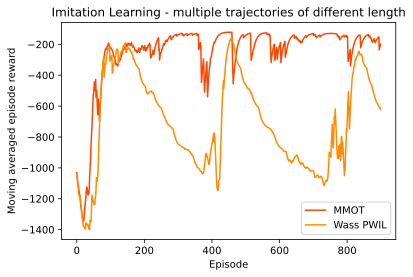

In [10]:
plt.plot([r.ep for r in training_records_diff_len_MMOT], [r.reward for r in training_records_diff_len_MMOT], color = 'orangered')
plt.plot([r.ep for r in training_records_diff_len_wass_PWIL], [r.reward for r in training_records_diff_len_wass_PWIL], color = 'darkorange')
    
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
    
plt.title('Imitation Learning - multiple trajectories of different length')
plt.legend(['MMOT', 'Wass PWIL'])

plt.savefig("/Users/ilanasebag/Documents/Thesis_code/IL_results/mult_traj_mult_len_environment_rewards_%s.png"%environment)

plt.show()